In [1]:
######################### Import #########################
import os
import re
import string
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
######################### Data #########################
os.chdir('/Users/biancaorozco/Desktop/Metis/project4/medium/data/')
df = pd.read_csv('Medium_Clean.csv').sample(250000)

/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
######################### Functions #########################
def space(string):
    
    return string + ' '

def add_space(series):
    new_series = pd.Series([])
    for string in series:
        new_string = pd.Series([space(string)])
        new_series = new_series.append(new_string)

    return new_series

# Preprocessing Text
def preprocessing(Series):
    new_series = pd.Series([])
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

    new_series = Series.map(alphanumeric).map(punc_lower)
    return new_series

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 200)

In [4]:
######################### Cleaning Data #########################
# Reverse Engineer Dummy Variables
categories = df.iloc[:,13:]
x = categories.stack()
tags = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

# Only want 4 columns for my new dataset
newdf = df.loc[:, ['Title', 'Subtitle', 'Claps']]

# Tag for each article
newdf['Tags'] = tags

# Claps from floats to integers
newdf['Claps'] = newdf['Claps'].astype(int)

data = newdf.dropna()
data = data.reset_index(drop=True)

# Adding a space to the end of each title; preparing to add subtitle 
title_series = add_space(data['Title'])

# Need to reset indices of both in order to replace Title column
title_series = title_series.reset_index(drop=True)
data.reset_index(drop=True)

# Replace old titles with new titles+space
data['Title'] = title_series

# Join Title + Subtitle and save to a new 'Text' column
data["Text"] = data["Title"].map(str) + data["Subtitle"]

In [5]:
######################### Documents Data #########################
docs = preprocessing(data['Text'])

In [6]:
######################### TF-IDF #########################
# unigrams and bigrams
tfidf = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english', min_df = 3, max_df = 0.75)
tfdocs = tfidf.fit_transform(docs)

# pd.DataFrame(tfdocs.toarray(), columns=tfidf.get_feature_names()).head()

In [7]:
######################### LSA #########################
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(4)
doc_topic = lsa.fit_transform(tfdocs)



# topic_word = pd.DataFrame(lsa.components_.round(3), 
#                           index = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20'], 
#                           columns = tfidf.get_feature_names())

# Vt = pd.DataFrame(doc_topic.round(5),
#              index = list(docs),
#              columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20'])

In [8]:
######################### Topics #########################
display_topics(lsa, tfidf.get_feature_names(),10)


Topic  0
new, time, people, like, world, best, know, life, day, make

Topic  1
com, https, tinyurl, tinyurl com, https tinyurl, pdf, pdf https, read, www, online

Topic  2
new, blockchain, data, bitcoin, ico, technology, platform, token, android, crypto

Topic  3
android, app, best, data, business, download, google, like, free, apk


217.38326653697257
164.096685727873
129.33826415489844
105.20893941377199


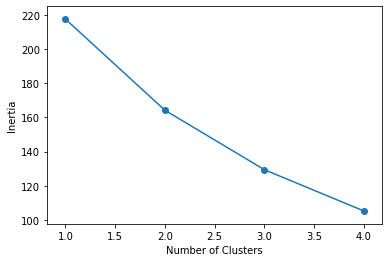

In [9]:
######################### K-Means Inertia #########################
inertia=[]
list_num_clusters = list(range(1,5))
for k in list_num_clusters:
    km = KMeans(n_clusters=k, init='k-means++', random_state=33)
    km.fit(doc_topic)
    print(km.inertia_)
    inertia.append(km.inertia_)

plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

105.20893941377199


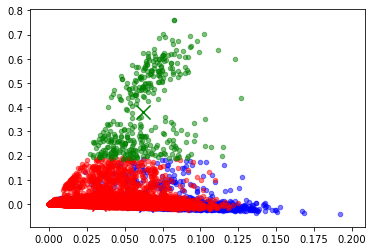

In [11]:
######################### K-Means Clustering #########################
km.fit(doc_topic)
print(km.inertia_)
display_cluster(doc_topic,km,num_clusters=3)